In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import matplotlib.image as mpim
import matplotlib.animation as animation

/tmp/ipykernel_719744/1616106777.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#open files
file = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NumuSelection_Modern_Uboone_Lite.root")
file2 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Numu_Lite.root")
file3 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Nu_Osc_Lite.root") 
file4 = uproot.open("/nevis/riverside/data/isafa/MC/output_SBNOsc_NueSelection_Modern_UBOONE_Intrinsic_Nue_Lite.root")

In [3]:
#grab the "protons on target" measurement for each dataset
pot = file["totpot"].member("fElements")[0] 
pot2 = file2["totpot"].member("fElements")[0]
pot3 = file3["totpot"].member("fElements")[0]
pot4 = file4["totpot"].member("fElements")[0]

#unpack each file and grab the relevant variables
Numu_cc = file["tree_numu_cc"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Numu_nc = file["tree_numu_nc"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_Numu = file2["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_NuOsc = file3["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")
Nue_Intrinsic = file4["simpletree"].arrays(["reco_energy","true_energy","nu_pdg","true_baseline","weight"], library="pd")

# doing our "final" weight calculation:
# weights = desired POT * simulated_weights / simulated_POT
des_pot = 1.2e+21
# using 1.2e21 as our desired POT as the ~total beam collected over microboone's lifetime
Numu_cc["pot_weight"] = Numu_cc["weight"] * (des_pot / pot)
Numu_nc["pot_weight"] = Numu_nc["weight"] * (des_pot / pot)
Nue_Numu["pot_weight"] = Nue_Numu["weight"] * (des_pot / pot2)
Nue_NuOsc["pot_weight"] = Nue_NuOsc["weight"] * (des_pot / pot3)
Nue_Intrinsic["pot_weight"] = Nue_Intrinsic["weight"] * (des_pot / pot4)


In [4]:
#split datasets into neutrino types
cc_mu = Numu_cc[(Numu_cc["nu_pdg"] == 14.0)]
cc_mua = Numu_cc[(Numu_cc["nu_pdg"] == -14.0)]
nc_mu = Numu_nc[(Numu_nc["nu_pdg"] == 14.0)]
nc_mua = Numu_nc[(Numu_nc["nu_pdg"] == -14.0)]
osc_e = Nue_NuOsc[(Nue_NuOsc["nu_pdg"] == 12.0)]
osc_ea = Nue_NuOsc[(Nue_NuOsc["nu_pdg"] == -12.0)]
intrin_e = Nue_Intrinsic[(Nue_Intrinsic["nu_pdg"] == 12.0)]
intrin_ea = Nue_Intrinsic[(Nue_Intrinsic["nu_pdg"] == -12.0)]

In [5]:
# FROM: https://microboone.fnal.gov/wp-content/uploads/MICROBOONE-NOTE-1116-PUB.pdf
#sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
#sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2
# sin2(2*theta_mumu) = 4*cos2(theta_14)*sin2(theta_24)*[1 - cos2(theta_14)*sin2(theta_24)] = 4 * (1-(U_m4)^2) * (U_m4)^2

# FROM: https://arxiv.org/pdf/1609.07803
# sin2(2*theta_mue) ~= 1/4 * sin2(2*theta_14) * sin2(2*theta_24)
# sin2(2*theta_ee) ~= sin2(2*theta_14)
# sin2(2*theta_mumu) ~= sin2(2*theta_24)

#best fit parameters from IceCube:
# deltm2_41 = 4.5 eV2
# sin2(2*theta_24) = 0.1

#best fit parameters from PROSPECT:
# deltm2_41 = 0.5 eV2
# sin2(2*theta_14) = 0.35

In [6]:
# probability for mu->e, e->e, and mu->mu oscillations
# in terms of Ue4, Um4, and deltam2_41
def prob_energy(params, deltam_41, L_E, Paa="mue", sin2s=False):
    if (sin2s==False):
        Ue4, Um4 = params
    
        # probability for mu->e oscillation (nue appearance)
        if (Paa=="mue"):
            #sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
            probab = ((4*(Ue4**2)*(Um4)**2) * (np.sin(1.27*deltam_41*L_E))**2)
        
        # probability for e->e (nue survival)
        elif (Paa=="ee"):
            #sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2
            probab =  1 - ((4*(Ue4**2)*(1-(Ue4)**2)) * (np.sin(1.27*deltam_41*L_E))**2)
        
        # probability for mu->mu (mue survival)
        elif (Paa=="mumu"):
            # sin2(2*theta_mumu) = 4*cos2(theta_14)*sin2(theta_24)*[1 - cos2(theta_14)*sin2(theta_24)] = 4 * (1-(U_m4)^2) * (U_m4)^2
            probab = 1 - ((4*(Um4**2)*(1-(Um4)**2)) * (np.sin(1.27*deltam_41*L_E))**2)
        
        else:
            print("Choose which oscillation type you want: mue, ee, mumu")
            return(0)
        
    else:
        sin2_14, sin2_24 = params
        
        # probability for mu->e oscillation (nue appearance)
        if (Paa=="mue"):
            #sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
            # sin2(2*theta_mue) ~= 1/4 * sin2(2*theta_14) * sin2(2*theta_24)
            probab = (0.25 * sin2_14 * sin2_24) * (np.sin(1.27*deltam_41*L_E))**2
        
        # probability for e->e (nue survival)
        elif (Paa=="ee"):
            #sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2
            # sin2(2*theta_ee) ~= sin2(2*theta_14)
            probab =  1 - ((sin2_14) * (np.sin(1.27*deltam_41*L_E))**2)
        
        # probability for mu->mu (mue survival)
        elif (Paa=="mumu"):
            # sin2(2*theta_mumu) = 4*cos2(theta_14)*sin2(theta_24)*[1 - cos2(theta_14)*sin2(theta_24)] = 4 * (1-(U_m4)^2) * (U_m4)^2
            # sin2(2*theta_mumu) ~= sin2(2*theta_24)
            probab = 1 - ((sin2_24) * (np.sin(1.27*deltam_41*L_E))**2)
        
        else:
            print("Choose which oscillation type you want: mue, ee, mumu")
            return(0)
        
    return(probab)


In [7]:
#if the expected count is 0, the sum goes to infinity, so just skip those boxes for right now
def chi2(expect, obs, distribution="poisson", dof_normalize=False, subtract_from_dof=0):
    if (np.isin(expect,0).any()):
        print("The expected freqency has a bin with 0 entries")
        return
    
    diff = expect - obs
    diff2 = diff**2
    
    if (distribution=="poisson"):
        diff3 = diff2/expect
        
    #elif (_______):
        # change the sigma/uncertainty based off of different expected distributions and fits
        # maybe also change the expected values? but that's less certain as the expected is currently just the intrinsic counts
        #   
        
    chi2 =0
    n = 0
    for i in diff3:
        n = n+1
        if (np.isinf(i)):
            continue
        chi2 = chi2 + i

    if(dof_normalize):
        dof = n - subtract_from_dof
        chi2 = chi2/dof
        #print("chi2 per dof (" + str(dof) +"): "+str(chi2))
        return chi2
    else:
        #print("total chi2: " + str(chi2))
        return chi2


In [8]:
#make a function that takes in oscillation parameters and the intrinsic and oscilation data and spits out the chi2 value
#def osc_chi2(deltam2, thetaee, thetamue, intrin_data, osc_data, n=1):

variable_bins = np.array([0.16, 0.46, 0.76, 1.06, 1.36, 1.66, 1.96, 2.26, 2.56, 2.86, 3.16, 3.46, 3.76, 4.06, 6.00])
bins_widths = np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.94])
bin_centers = np.array([0.31, 0.61, 0.91, 1.21, 1.51, 1.81, 2.11, 2.41, 2.71, 3.01, 3.31, 3.61, 3.91, 5.03])

#unosc_intriniscnue_mc and fullosc_mc
def osc_chi2(params, unosc_intrinsic_nue_mc, fullosc_mc, n=1, sin2s=False):
    if sin2s==False:
        deltam2, Ue4, Um4 = params
        nue_survival_probs = prob_energy([Ue4, Um4], deltam2, (unosc_intrinsic_nue_mc["true_baseline"]/1000)/unosc_intrinsic_nue_mc["true_energy"], Paa="ee")
        nue_appearance_probs = prob_energy([Ue4, Um4], deltam2, (fullosc_mc["true_baseline"]/1000)/fullosc_mc["true_energy"], Paa="mue")
    else:
        deltam2, sin2_14, sin2_24= params
        nue_survival_probs = prob_energy([sin2_14, sin2_24], deltam2, (unosc_intrinsic_nue_mc["true_baseline"]/1000)/unosc_intrinsic_nue_mc["true_energy"], Paa="ee", sin2s=True)
        nue_appearance_probs = prob_energy([sin2_14, sin2_24], deltam2, (fullosc_mc["true_baseline"]/1000)/fullosc_mc["true_energy"], Paa="mue", sin2s=True)
        
    
    nue_survival_weight = unosc_intrinsic_nue_mc["pot_weight"] * nue_survival_probs
    nue_appearance_weight = fullosc_mc["pot_weight"] * nue_appearance_probs
    
    nue_intrinsic = np.histogram(unosc_intrinsic_nue_mc["true_energy"], bins=variable_bins, weights=unosc_intrinsic_nue_mc["pot_weight"]) #total intrinsic nue
    #plt.stairs(nue_intrinsic[0]/bins_widths, nue_intrinsic[1])
    #plt.show()
       
    nue_survival = np.histogram(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], weights=nue_survival_weight) #intrinsic nue with oscillation disappearance
    nue_appearance = np.histogram(fullosc_mc["true_energy"], bins=nue_intrinsic[1], weights=nue_appearance_weight) #oscilated numu->nue
    
    chi2_val = chi2(nue_intrinsic[0], nue_survival[0]+nue_appearance[0], dof_normalize=False, subtract_from_dof=2)
    
    #to use in minimize functions to find parameters with specific chi2 values
    # specify here what value to subtract off (the chi2 value you're targeting
    wanted_value = 0
    
    #if (chi2_val > 5):
    #plt.subplot(sin2s_mue.shape[0], deltam2s.shape[0],n)
        # plt.hist([unosc_intrinsic_nue_mc["true_energy"], fullosc_mc["true_energy"]], bins=nue_intrinsic[1], histtype="barstacked", edgecolor="black", label=["Intrinsic Survival Nue","Appearance Nue"], weights=[nue_survival_weight,nue_appearance_weight])
        # plt.hist(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], color="red", histtype="step", label="Unoscillated Intrinsic Nue", weights=unosc_intrinsic_nue_mc["pot_weight"])
        # plt.errorbar(bin_centers,nue_intrinsic[0], yerr=np.sqrt(nue_intrinsic[0]), fmt=" ", color="red", capsize=5)
        # plt.errorbar(bin_centers, nue_survival[0]+nue_appearance[0], yerr= np.sqrt(nue_survival[0]+nue_appearance[0]), fmt=" ", color="black", capsize=5)
        # plt.legend()
        # plt.ylabel("Events")
        # plt.xlabel("Energy {GeV}")
        # plt.title("Intrinsic and Oscillated $\\nu_e$ \n$\Delta{m}^2=$" + str(deltam2) + " and $sin^2(2\\theta_{mue})=$" + str(sin2mue) + " and $sin^2(2\\theta_{ee})=$" + str(sin2ee) + "\n$\\chi^2=$" + str(round(chi2_val,5)))
        # plt.show()
    
    return (chi2_val-wanted_value)

In [9]:
deltam2s = np.logspace(np.log10(0.1),np.log10(10),30, base=10)

#if I want sin2_mue = [1e-5, 0.1] and sin2_ee = [0,0.5]
#sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
#sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2

Ue4s = np.logspace(np.log10(0.01), np.log10(0.4), 30, base=10)
Um4s = np.logspace(np.log10(0.01), np.log10(0.4), 30, base=10)

In [10]:
#try a 3D plot
# chi2_3d = np.zeros((deltam2s.shape[0],Ue4s.shape[0], Um4s.shape[0]))

# start= time.time()
# for i in range(deltam2s.shape[0]):
#     print("Event i:", str(i))
#     t = time.time() - start
#     print("Time elapsed in seconds since starting cell:", str(t))
#     for j in range(Ue4s.shape[0]):
#         for k in range(Um4s.shape[0]):
#             chi2_3d[i][j][k] = osc_chi2((deltam2s[i], Ue4s[j], Um4s[k]), intrin_e, osc_e)
#             #print("Event " + str(i) + "-" + str(j) + "-" + str(k) + " completed")
#         #n = n+1
 
    
# np.save("chi23d_30x30x30_array.npy", chi2_3d)

In [11]:
# DO THIS ONE!!
#load in the 30x30x30 dataset

chi2_3d =  np.load("chi23d_30x30x30_array.npy")

Text(0.5, 0.92, '$\\chi^2$ Sensitivity to Variations in $U_{e4}^2$, $U_{\\mu4}^2$, and $\\Delta{m}_{mue}^2$')

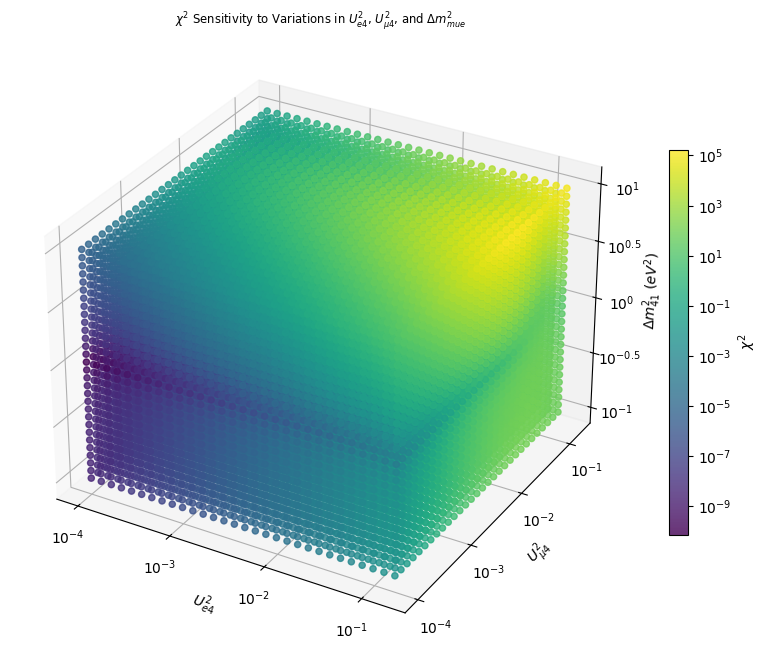

In [12]:
#try plotting a 3d scatterplot with colors=chi2 correspondance (no contours)

#apparantly you can't do a log scale axis in 3d scatterplot, so manually take the log myself, then plot on a linear scale
#Ue4_3d, Um4_3d, deltm3d = np.meshgrid(Ue4s, Um4s, deltam2s) 

#try doing it with Ue4^2 and Um4^2
Ue4_3d, Um4_3d, deltm3d = np.meshgrid(Ue4s**2, Um4s**2, deltam2s)

Ue4_3d_log = np.log10(Ue4_3d)
Um4_3d_log = np.log10(Um4_3d)
deltm3d_log = np.log10(deltm3d)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")

scattr = ax.scatter3D(Ue4_3d_log, Um4_3d_log, deltm3d_log, c=chi2_3d, norm="log", alpha=0.8)
ax.set_xlabel("$U_{e4}^2$")
ax.set_xticks([-4,-3,-2,-1], labels=["$10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$"])
ax.set_ylabel("$U_{\mu4}^2$")
ax.set_yticks([-4,-3,-2,-1], labels=["$10^{-4}$", "$10^{-3}$", "$10^{-2}$", "$10^{-1}$"])
ax.set_zlabel("$\Delta{m}^2_{41}$ ($eV^2$)")
ax.set_zticks([-1,-0.5,0,0.5,1], labels=["$10^{-1}$", "$10^{-0.5}$", "$10^{0}$", "$10^{0.5}$", "$10^{1}$"])

fig.colorbar(scattr, label="$\\chi^2$", shrink=0.5, location="right") 
ax.set_title("$\chi^2$ Sensitivity to Variations in $U_{e4}^2$, $U_{\mu4}^2$, and $\\Delta{m}_{mue}^2$", fontsize="small")



In [13]:
# assign significant values for chi2
# # 2 degrees of freedom
# dof = 2
# cl_90 = 4.605
# cl_99 = 9.210
# cl_999 = 13.816

# 3 degrees of freedom
dof = 3
cl_90 = 6.251
cl_99 = 11.345
cl_999 = 16.266

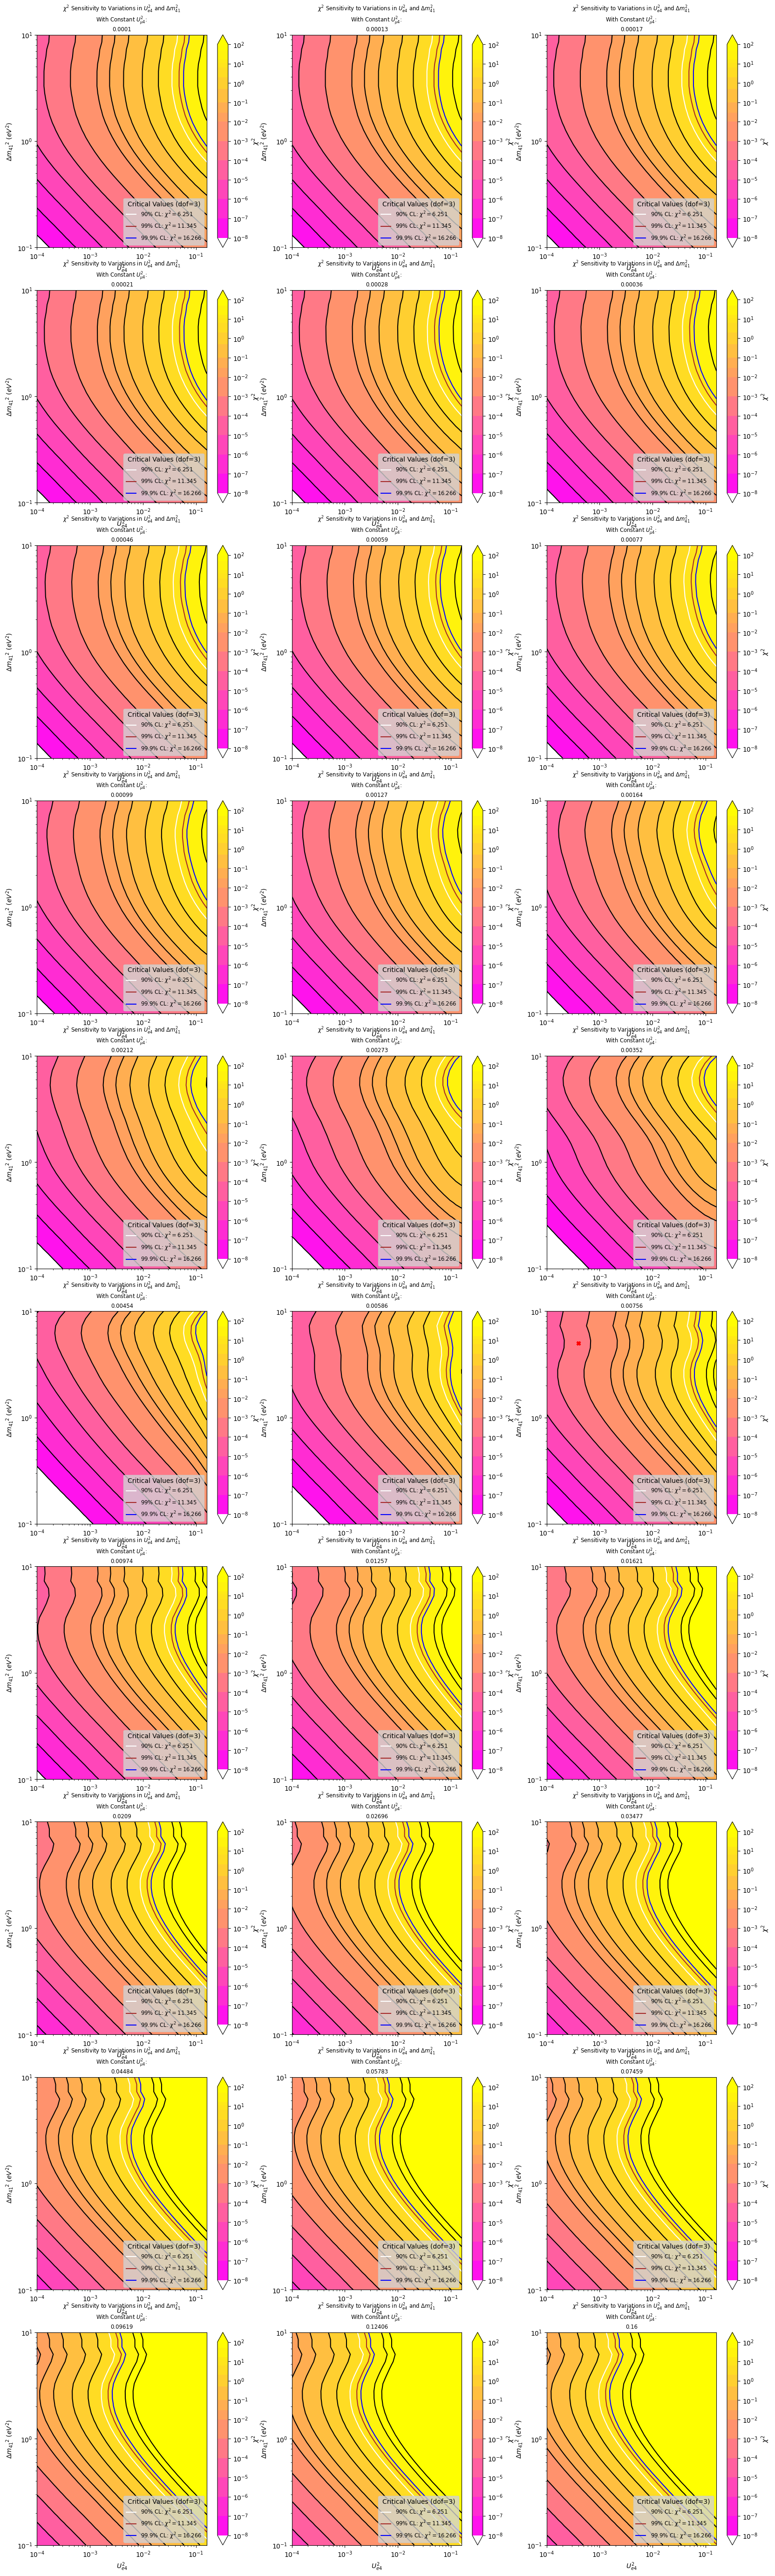

In [32]:
deltam2s = np.logspace(np.log10(0.1),np.log10(10),30, base=10)

#if I want sin2_mue = [1e-5, 0.1] and sin2_ee = [0,0.5]
#sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
#sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2

Ue4s = np.logspace(np.log10(0.01), np.log10(0.4), 30, base=10)
Um4s = np.logspace(np.log10(0.01), np.log10(0.4), 30, base=10)


# make contour plots in U_e4 and deltam_41 plane 
plt.figure(figsize=(20,70))
for i in range(Um4s.shape[0]):
    
    plt.subplot(10,3,i+1)
    plt.contourf(Ue4s**2,deltam2s,chi2_3d[:,:,i],extend="both", norm="log",levels=[1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,0.03,0.1, 0.5,2,cl_90,cl_99,cl_999,50,100], cmap="spring")#, colors=["red","orange","yellow","green","blue","purple","pink"])
    plt.yscale("log")
    plt.xscale("log")
    cbar = plt.colorbar(label="$\chi^2$")
    cbar.set_ticks([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,0.01,0.1,1,10,100])

    CL = plt.contour(Ue4s**2,deltam2s, chi2_3d[:,:,i], norm="linear", levels=[0.01, 0.03, 0.1, 0.5,2], colors="black")
    #manual_locations = [(0.1,0.1),(0.41, 0.1), (0.37,0.2), (0.33, 0.3),(0.29, 0.4)]
    #plt.clabel(CL, inline=True, manual = manual_locations)
    CL1 = plt.contour(Ue4s**2,deltam2s, chi2_3d[:,:,i], norm="log", levels=[50,100], colors="black")
    #manual_locations1 = [(0.4,3)]
    #plt.clabel(CL1, inline=True, manual = manual_locations1)
    CL2 = plt.contour(Ue4s**2,deltam2s, chi2_3d[:,:,i], norm="log", levels=[cl_90, cl_99, cl_999], colors=["white","brown","blue"])
    critical_colors,critical_labels = CL2.legend_elements()
    #manual_locations2 = [(0.25,1),(0.25, 1.5),(0.25, 3)]
    #plt.clabel(CL2, inline=True, manual = manual_locations2)
    CL3 = plt.contour(Ue4s**2,deltam2s, chi2_3d[:,:,i], norm="linear", levels=[1e-8,1e-7,1e-6,1e-5,1e-4,1e-3], colors="black")
    #manual_locations3 = [(0.04, 0.15)]
    #plt.clabel(CL3, inline=True, manual = manual_locations3)
    
    plt.xlabel("$U_{e4}^2$")
    plt.ylabel("$\\Delta{m_{41}}^2$ $(eV^2)$")
    plt.title("$\chi^2$ Sensitivity to Variations in $U_{e4}^2$ and $\\Delta{m^2_{41}}$ \nWith Constant $U_{\\mu4}^2$: \n" + str(round(Um4s[i]**2,5)), fontsize="small")
    plt.legend(critical_colors, ["90% CL: $\chi^2=$"+str(cl_90), "99% CL: $\chi^2=$"+str(cl_99), "99.9% CL: $\chi^2=$"+str(cl_999)], loc="lower right", facecolor="lightgray", title="Critical Values (dof="+str(dof)+")", fontsize="small")

    if (i==17):
        plt.scatter(0.02**2,5, color="red", marker="X")
    
    

In [15]:
# #make gif
# for i in range(Um4s.shape[0]):
#     plt.figure(figsize=(5,5))
#     plt.contourf(Ue4s**2,deltam2s,chi2_3d[:,:,i],extend="both", norm="log",levels=[1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,0.03,0.1, 0.5,2,cl_90,cl_99,cl_999,50,100], cmap="spring")#, colors=["red","orange","yellow","green","blue","purple","pink"])
#     plt.yscale("log")
#     plt.xscale("log")
#     cbar = plt.colorbar(label="$\chi^2$")
#     cbar.set_ticks([1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,0.01,0.1,1,10,100])

#     CL = plt.contour(Ue4s**2,deltam2s, chi2_3d[:,:,i], norm="linear", levels=[0.001,0.01, 0.03, 0.1, 0.5,2], colors="black")
#     #manual_locations = [(0.1,0.1),(0.41, 0.1), (0.37,0.2), (0.33, 0.3),(0.29, 0.4)]
#     #plt.clabel(CL, inline=True, manual = manual_locations)
#     CL1 = plt.contour(Ue4s**2,deltam2s, chi2_3d[:,:,i], norm="log", levels=[50,100], colors="black")
#     #manual_locations1 = [(0.4,3)]
#     #plt.clabel(CL1, inline=True, manual = manual_locations1)
#     CL2 = plt.contour(Ue4s**2,deltam2s, chi2_3d[:,:,i], norm="log", levels=[cl_90,cl_99,cl_999], colors=["white","brown","blue"])
#     critical_colors,critical_labels = CL2.legend_elements()
#     #manual_locations2 = [(0.25,1),(0.25, 1.5),(0.25, 3)]
#     #plt.clabel(CL2, inline=True, manual = manual_locations2)
#     CL3 = plt.contour(Ue4s**2,deltam2s, chi2_3d[:,:,i], norm="linear", levels=[1e-8,1e-7,1e-6,1e-5,1e-4,1e-3], colors="black")
#     #manual_locations3 = [(0.04, 0.15)]
#     #plt.clabel(CL3, inline=True, manual = manual_locations3)
    
#     plt.xlabel("$U_{e4}^2$")
#     plt.ylabel("$\\Delta{m_{41}}^2$ $(eV^2)$")
#     plt.title("$\chi^2$ Sensitivity to Variations in $U_{e4}^2$ and $\\Delta{m^2_{41}}$ \nWith Constant $U_{\\mu4}^2$: \n" + str(round(Um4s[i]**2,5)), fontsize="small")
#     plt.legend(critical_colors, ["90% CL: $\chi^2=$"+str(cl_90), "99% CL: $\chi^2=$"+str(cl_99), "99.9% CL: $\chi^2=$"+str(cl_999)], loc="lower right", facecolor="lightgray", title="Critical Values (dof="+str(dof)+")", fontsize="small")

#     name = "Ufigs/fig"+str(i)
#     plt.savefig(name, format="png", bbox_inches="tight")
#     plt.close()
    
    
# #combine the 2d contour plots into a single gif
# k = []

# for i in range(Um4s.shape[0]):
#     name = "Ufigs/fig" + str(i)
#     k.append(mpim.imread(name))
    
    

# # Create the figure and axes objects
# fig, ax = plt.subplots()

# # Set the initial image
# im = ax.imshow(k[0], animated=True)

# def update(i):
#     im.set_array(k[i])
#     return im, 

# # Create the animation object
# animation_fig = animation.FuncAnimation(fig, update, frames=len(k), interval=200, blit=True,repeat_delay=10,)

# # Show the animation
# plt.show()

# animation_fig.save("U4s_30x30_animated_3dplot_dof3.gif")

In [16]:
#make a function that takes in oscillation parameters and the intrinsic and oscilation data and spits out the chi2 value
#def osc_chi2(deltam2, thetaee, thetamue, intrin_data, osc_data, n=1):

variable_bins = np.array([0.16, 0.46, 0.76, 1.06, 1.36, 1.66, 1.96, 2.26, 2.56, 2.86, 3.16, 3.46, 3.76, 4.06, 6.00])
bins_widths = np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 1.94])
bin_centers = np.array([0.31, 0.61, 0.91, 1.21, 1.51, 1.81, 2.11, 2.41, 2.71, 3.01, 3.31, 3.61, 3.91, 5.03])

#unosc_intriniscnue_mc and fullosc_mc
def find_reversal(params, unosc_intrinsic_nue_mc, fullosc_mc, n=1, sin2s=False):
    if sin2s==False:
        deltam2, Ue4, Um4 = params
        nue_survival_probs = prob_energy([Ue4, Um4], deltam2, (unosc_intrinsic_nue_mc["true_baseline"]/1000)/unosc_intrinsic_nue_mc["true_energy"], Paa="ee")
        nue_appearance_probs = prob_energy([Ue4, Um4], deltam2, (fullosc_mc["true_baseline"]/1000)/fullosc_mc["true_energy"], Paa="mue")
    else:
        deltam2, sin2_14, sin2_24= params
        nue_survival_probs = prob_energy([sin2_14, sin2_24], deltam2, (unosc_intrinsic_nue_mc["true_baseline"]/1000)/unosc_intrinsic_nue_mc["true_energy"], Paa="ee", sin2s=True)
        nue_appearance_probs = prob_energy([sin2_14, sin2_24], deltam2, (fullosc_mc["true_baseline"]/1000)/fullosc_mc["true_energy"], Paa="mue", sin2s=True)
        
    
    nue_survival_weight = unosc_intrinsic_nue_mc["pot_weight"] * nue_survival_probs
    nue_appearance_weight = fullosc_mc["pot_weight"] * nue_appearance_probs
    
    nue_intrinsic = np.histogram(unosc_intrinsic_nue_mc["true_energy"], bins=variable_bins, weights=unosc_intrinsic_nue_mc["pot_weight"]) #total intrinsic nue
    #plt.stairs(nue_intrinsic[0]/bins_widths, nue_intrinsic[1])
    #plt.show()
       
    nue_survival = np.histogram(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], weights=nue_survival_weight) #intrinsic nue with oscillation disappearance
    nue_appearance = np.histogram(fullosc_mc["true_energy"], bins=nue_intrinsic[1], weights=nue_appearance_weight) #oscilated numu->nue
    
    
    #find the number of disappearance and appearance nue
    nue_dis = nue_intrinsic[0] - nue_survival[0]
    nue_diff = nue_dis - nue_appearance[0]
    total_diff = np.sum(nue_diff)
    
    print("Um4, Ue4, deltm2:", Um4, Ue4, deltam2)
    print("total_diff", total_diff)
    
    # if (total_diff < 0.000001):
    #     #print("nue_dis", nue_dis)
    #     #print("nue_app", nue_appearance)
    #     print("Um4, Ue4, deltm2:", Um4, Ue4, deltam2)
    #     print("nue_dis - nue_app", nue_diff)
    #     print("total_diff", total_diff)
    # elif (np.any(np.isin(nue_diff, 0))):
    #     print("Um4, Ue4, deltm2:", Um4, Ue4, deltam2)
    #     print("nue_dis - nue_app", nue_diff)
    #     print("total_diff", total_diff)
    
    #if (chi2_val > 5):
    #plt.subplot(sin2s_mue.shape[0], deltam2s.shape[0],n)
        # plt.hist([unosc_intrinsic_nue_mc["true_energy"], fullosc_mc["true_energy"]], bins=nue_intrinsic[1], histtype="barstacked", edgecolor="black", label=["Intrinsic Survival Nue","Appearance Nue"], weights=[nue_survival_weight,nue_appearance_weight])
        # plt.hist(unosc_intrinsic_nue_mc["true_energy"], bins=nue_intrinsic[1], color="red", histtype="step", label="Unoscillated Intrinsic Nue", weights=unosc_intrinsic_nue_mc["pot_weight"])
        # plt.errorbar(bin_centers,nue_intrinsic[0], yerr=np.sqrt(nue_intrinsic[0]), fmt=" ", color="red", capsize=5)
        # plt.errorbar(bin_centers, nue_survival[0]+nue_appearance[0], yerr= np.sqrt(nue_survival[0]+nue_appearance[0]), fmt=" ", color="black", capsize=5)
        # plt.legend()
        # plt.ylabel("Events")
        # plt.xlabel("Energy {GeV}")
        # plt.title("Intrinsic and Oscillated $\\nu_e$ \n$\Delta{m}^2=$" + str(deltam2) + " and $sin^2(2\\theta_{mue})=$" + str(sin2mue) + " and $sin^2(2\\theta_{ee})=$" + str(sin2ee) + "\n$\\chi^2=$" + str(round(chi2_val,5)))
        # plt.show()
    
    return

In [17]:
Um4s

array([0.01      , 0.01135647, 0.01289695, 0.01464638, 0.01663312,
       0.01888936, 0.02145165, 0.02436151, 0.02766608, 0.0314189 ,
       0.03568079, 0.04052079, 0.04601733, 0.05225945, 0.0593483 ,
       0.06739873, 0.07654118, 0.08692378, 0.09871475, 0.11210514,
       0.12731189, 0.14458139, 0.16419346, 0.18646585, 0.21175943,
       0.24048401, 0.273105  , 0.31015094, 0.35222205, 0.4       ])

In [18]:
#in the plot above, the trend reverses itself
# this happens when the number of appearance and disappearance nue equal and then swap in magnitude
# this happens at:


#try a 3D plot
# chi2_3d = np.zeros((deltam2s.shape[0],Ue4s.shape[0], Um4s.shape[0]))

deltam2s = np.array([5])

#if I want sin2_mue = [1e-5, 0.1] and sin2_ee = [0,0.5]
#sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
#sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2

#Ue4s = np.logspace(np.log10(0.01), np.log10(0.4), 30, base=10)
#Um4s = np.logspace(np.log10(0.085), np.log10(0.088), 3, base=10)
Um4s = np.array([0.086])

start= time.time()
for i in range(deltam2s.shape[0]):
    print("Event i:", str(i))
    t = time.time() - start
    print("Time elapsed in seconds since starting cell:", str(t))
    for j in range(Ue4s.shape[0]):
        for k in range(Um4s.shape[0]):
            find_reversal((deltam2s[i], Ue4s[j], Um4s[k]), intrin_e, osc_e)
            #print("Event " + str(i) + "-" + str(j) + "-" + str(k) + " completed")
        #n = n+1
 
    
# np.save("chi23d_30x30x30_array.npy", chi2_3d)

Event i: 0
Time elapsed in seconds since starting cell: 0.0001773834228515625
Um4, Ue4, deltm2: 0.086 0.01 5
total_diff -0.0034423679906511184
Um4, Ue4, deltm2: 0.086 0.011356472353335596 5
total_diff -0.004446175821799125
Um4, Ue4, deltm2: 0.086 0.012896946431207581 5
total_diff -0.005745140733072862
Um4, Ue4, deltm2: 0.086 0.014646381558845907 5
total_diff -0.007427659746303494
Um4, Ue4, deltm2: 0.086 0.016633122724943786 5
total_diff -0.009609656041113412
Um4, Ue4, deltm2: 0.086 0.018889359837546225 5
total_diff -0.012443825426469712
Um4, Ue4, deltm2: 0.086 0.02145164927673015 5
total_diff -0.016132405292028418
Um4, Ue4, deltm2: 0.086 0.024361506194463745 5
total_diff -0.02094504638839534
Um4, Ue4, deltm2: 0.086 0.02766607715830414 5
total_diff -0.02724419665099731
Um4, Ue4, deltm2: 0.086 0.03141890403735304 5
total_diff -0.03552172205575199
Um4, Ue4, deltm2: 0.086 0.035680791507230414 5
total_diff -0.046452595597307855
Um4, Ue4, deltm2: 0.086 0.04052079222969938 5
total_diff -0.060

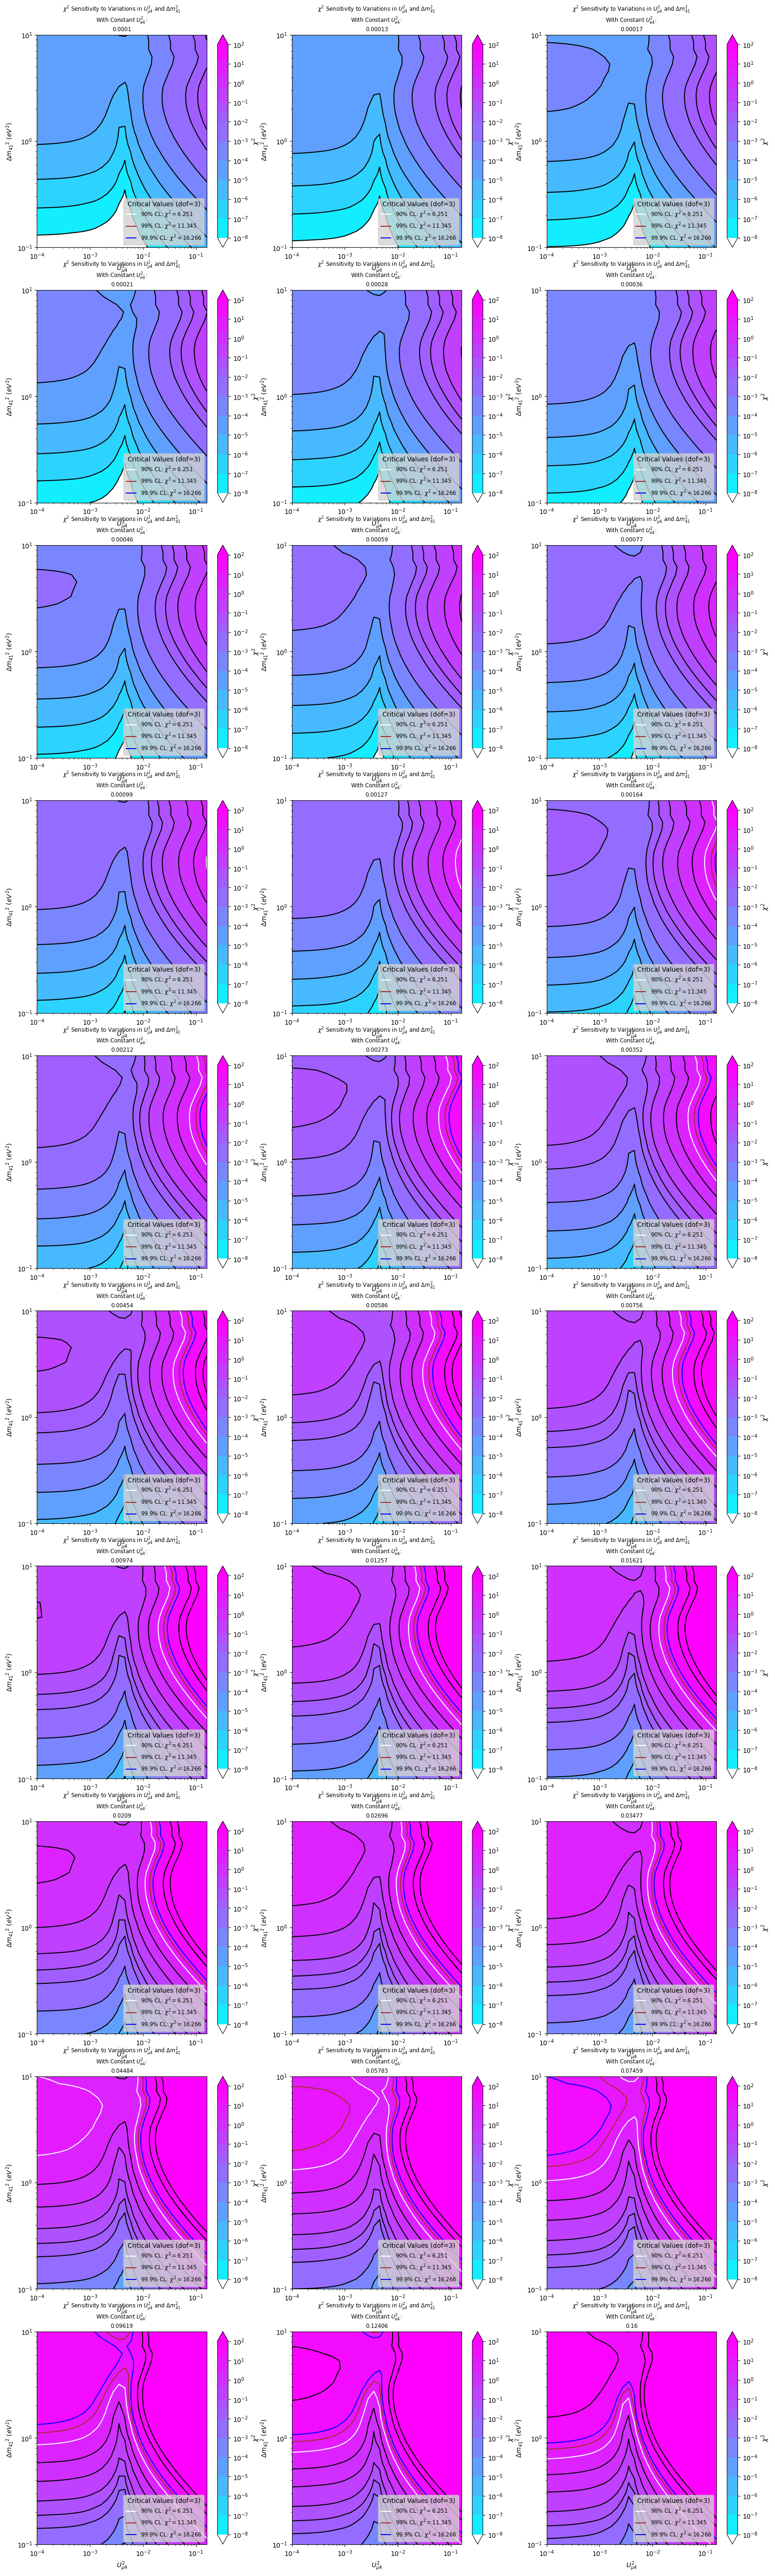

In [84]:
#make contour plots in U_m4 and deltm_41 plane
plt.figure(figsize=(20,70))
for i in range(Ue4s.shape[0]):
    
    plt.subplot(10,3,i+1)
    plt.contourf(Um4s**2,deltam2s,chi2_3d[:,i,:],extend="both", norm="log",levels=[1e-8, 1e-7, 1e-6, 0.00001,0.0001,0.001,0.01,0.03,0.1, 0.5,2,cl_90,cl_99,cl_999,50,100], cmap="cool")#, colors=["red","orange","yellow","green","blue","purple","pink"])
    plt.yscale("log")
    plt.xscale("log")
    cbar = plt.colorbar(label="$\chi^2$")
    cbar.set_ticks([1e-8, 1e-7, 1e-6, 0.00001, 0.0001, 0.001,0.01,0.1,1,10,100])

    CL = plt.contour(Um4s**2,deltam2s, chi2_3d[:,i,:], norm="linear", levels=[0.001,0.01, 0.03, 0.1, 0.5,2], colors="black")
    #manual_locations = [(0.1,0.1),(0.41, 0.1), (0.37,0.2), (0.33, 0.3),(0.29, 0.4)]
    #plt.clabel(CL, inline=True, manual = manual_locations)
    CL1 = plt.contour(Um4s**2,deltam2s, chi2_3d[:,i,:], norm="log", levels=[50,100], colors="black")
    #manual_locations1 = [(0.4,3)]
    #plt.clabel(CL1, inline=True, manual = manual_locations1)
    CL2 = plt.contour(Um4s**2,deltam2s, chi2_3d[:,i,:], norm="log", levels=[cl_90,cl_99,cl_999], colors=["white","brown","blue"])
    critical_colors,critical_labels = CL2.legend_elements()
    #manual_locations2 = [(0.25,1),(0.25, 1.5),(0.25, 3)]
    #plt.clabel(CL2, inline=True, manual = manual_locations2)
    CL3 = plt.contour(Um4s**2,deltam2s, chi2_3d[:,i,:], norm="linear", levels=[0.0001], colors="black")
    #manual_locations3 = [(0.04, 0.15)]
    #plt.clabel(CL3, inline=True, manual = manual_locations3)
    CL3 = plt.contour(Um4s**2,deltam2s, chi2_3d[:,i,:], norm="linear", levels=[1e-8,1e-7, 1e-6, 0.00001], colors="black")
    #manual_locations3 = []
    #plt.clabel(CL3, inline=True, manual = manual_locations3)
    
    plt.xlabel("$U_{\\mu4}^2$")
    plt.ylabel("$\\Delta{m_{41}}^2$ $(eV^2)$")
    plt.title("$\chi^2$ Sensitivity to Variations in $U_{\\mu4}^2$ and $\\Delta{m^2_{41}}$ \nWith Constant $U_{e4}^2$: \n" + str(round(Ue4s[i]**2,5)), fontsize="small")
    plt.legend(critical_colors, ["90% CL: $\chi^2=$"+str(cl_90), "99% CL: $\chi^2=$"+str(cl_99), "99.9% CL: $\chi^2=$"+str(cl_999)], loc="lower right", facecolor="lightgray", title="Critical Values (dof="+str(dof)+")", fontsize="small")

       

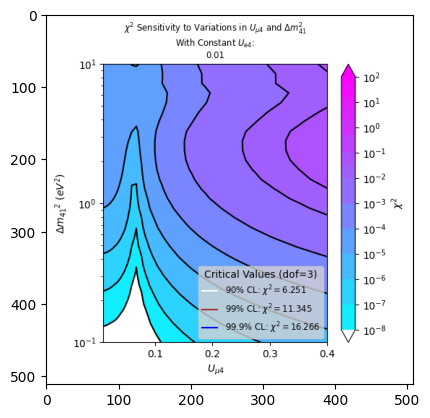

MovieWriter ffmpeg unavailable; using Pillow instead.


In [43]:
# #make gif
# for i in range(Ue4s.shape[0]):
#     plt.figure(figsize=(5,5))
#     plt.contourf(Um4s**2,deltam2s,chi2_3d[:,i,:],extend="both", norm="log",levels=[1e-8, 1e-7, 1e-6, 0.00001,0.0001,0.001,0.01,0.03,0.1, 0.5,2,cl_90,cl_99,cl_999,50,100], cmap="cool")#, colors=["red","orange","yellow","green","blue","purple","pink"])
#     plt.yscale("log")
#     plt.xscale("log")
#     cbar = plt.colorbar(label="$\chi^2$")
#     cbar.set_ticks([1e-8, 1e-7, 1e-6, 0.00001, 0.0001, 0.001,0.01,0.1,1,10,100])

#     CL = plt.contour(Um4s**2,deltam2s, chi2_3d[:,i,:], norm="linear", levels=[0.001,0.01, 0.03, 0.1, 0.5,2], colors="black")
#     #manual_locations = [(0.1,0.1),(0.41, 0.1), (0.37,0.2), (0.33, 0.3),(0.29, 0.4)]
#     #plt.clabel(CL, inline=True, manual = manual_locations)
#     CL1 = plt.contour(Um4s**2,deltam2s, chi2_3d[:,i,:], norm="log", levels=[50,100], colors="black")
#     #manual_locations1 = [(0.4,3)]
#     #plt.clabel(CL1, inline=True, manual = manual_locations1)
#     CL2 = plt.contour(Um4s**2,deltam2s, chi2_3d[:,i,:], norm="log", levels=[cl_90,cl_99,cl_999], colors=["white","brown","blue"])
#     critical_colors,critical_labels = CL2.legend_elements()
#     #manual_locations2 = [(0.25,1),(0.25, 1.5),(0.25, 3)]
#     #plt.clabel(CL2, inline=True, manual = manual_locations2)
#     CL3 = plt.contour(Um4s**2,deltam2s, chi2_3d[:,i,:], norm="linear", levels=[0.0001], colors="black")
#     #manual_locations3 = [(0.04, 0.15)]
#     #plt.clabel(CL3, inline=True, manual = manual_locations3)
#     CL3 = plt.contour(Um4s**2,deltam2s, chi2_3d[:,i,:], norm="linear", levels=[1e-8,1e-7, 1e-6, 0.00001], colors="black")
#     #manual_locations3 = []
#     #plt.clabel(CL3, inline=True, manual = manual_locations3)
    
#     plt.xlabel("$U_{\\mu4}^2$")
#     plt.ylabel("$\\Delta{m_{41}}^2$ $(eV^2)$")
#     plt.title("$\chi^2$ Sensitivity to Variations in $U_{\\mu4}^2$ and $\\Delta{m^2_{41}}$ \nWith Constant $U_{e4}^2$: \n" + str(round(Ue4s[i]**2,5)), fontsize="small")
#     plt.legend(critical_colors, ["90% CL: $\chi^2=$"+str(cl_90), "99% CL: $\chi^2=$"+str(cl_99), "99.9% CL: $\chi^2=$"+str(cl_999)], loc="lower right", facecolor="lightgray", title="Critical Values (dof="+str(dof)+")", fontsize="small")


#     name = "U2figs/fig"+str(i)
#     plt.savefig(name, format="png", bbox_inches="tight")
#     plt.close()
    
    
    
# #combine the 2d contour plots into a single gif
# k = []

# for i in range(Ue4s.shape[0]):
#     name = "U2figs/fig" + str(i)
#     k.append(mpim.imread(name))
    

# # Create the figure and axes objects
# fig, ax = plt.subplots()

# # Set the initial image
# im = ax.imshow(k[0], animated=True)

# def update(i):
#     im.set_array(k[i])
#     return im, 

# # Create the animation object
# animation_fig = animation.FuncAnimation(fig, update, frames=len(k), interval=200, blit=True,repeat_delay=10,)

# # Show the animation
# plt.show()

# animation_fig.save("U4s_v2_30x30_animated_3dplot_dof3.gif")

In [ ]:
# FROM: https://microboone.fnal.gov/wp-content/uploads/MICROBOONE-NOTE-1116-PUB.pdf
#sin2(2*theta_mue) = sin2(2*theta_14)sin2(theta_24) = 4 * (U_m4)^2 * (U_e4)^2
#sin2(2*theta_ee) = sin2(2*theta_14) = 4 * (1-(U_e4)^2) * (U_e4)^2
# sin2(2*theta_mumu) = 4*cos2(theta_14)*sin2(theta_24)*[1 - cos2(theta_14)*sin2(theta_24)] = 4 * (1-(U_m4)^2) * (U_m4)^2

# FROM: https://arxiv.org/pdf/1609.07803
# sin2(2*theta_mue) ~= 1/4 * sin2(2*theta_14) * sin2(2*theta_24)
# sin2(2*theta_ee) ~= sin2(2*theta_14)
# sin2(2*theta_mumu) ~= sin2(2*theta_24)

#best fit parameters from IceCube:
# deltm2_41 = 4.5 eV2
# sin2(2*theta_24) = 0.1

#best fit parameters from PROSPECT:
# deltm2_41 = 0.5 eV2
# sin2(2*theta_14) = 0.35

In [92]:
#testing the approximation given above
theta14 = np.arcsin(np.sqrt(0.35))/2
theta24 = np.arcsin(np.sqrt(0.1))/2

a1 = 0.25*0.35*0.1
b1 = 0.35
c1 = 0.1

a2 = 0.25*np.sin(theta24)**2
b2 = 0.35
c2 = 4*np.cos(theta14)**2 * np.sin(theta24)**2 * (1 - np.cos(theta14)**2 * np.sin(theta24)**2)

print(a1, a2)
print(b1, b2)
print(c1, c2)

0.008749999999999999 0.006414587743685774
0.35 0.35
0.1 0.09054171158265283


In [113]:
icecube_bestfit = osc_chi2([4.5,0.35,0.1], intrin_e, osc_e, sin2s=True)
prospect_bestfit = osc_chi2([0.5,0.35,0.1], intrin_e, osc_e, sin2s=True)

print(icecube_bestfit)
print(prospect_bestfit)

443.2447003029491
26.408091382559455
